In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

# EVT 

In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [3]:
def bg_cdf(z: np.ndarray, z_star: float, beta: float, gamma: float) -> np.ndarray:
    return np.exp(-((gamma / beta * (z - z_star)) ** (-1 / gamma)))


def bg_pdf(z: np.ndarray, z_star: float, beta: float, gamma: float) -> np.ndarray:
    return (
        1
        / beta
        * (gamma / beta * (z - z_star)) ** (-1 / gamma - 1)
        * np.exp(-((gamma / beta * (z - z_star)) ** (-1 / gamma)))
    )


def gev_pdf(z: np.ndarray, alpha: float, beta: float, gamma: float) -> np.ndarray:
    return (
        1
        / beta
        * (1 + gamma * (z - alpha) / beta) ** (-1 / gamma - 1)
        * np.exp(-((1 + gamma * (z - alpha) / beta) ** (-1 / gamma)))
    )


# assume gamma < 0
def z_star_from_alpha_beta_gamma(alpha: float, beta: float, gamma: float) -> float:
    return alpha - beta / gamma


def alpha_from_z_star_beta_gamma(z_star: float, beta: float, gamma: float) -> float:
    return z_star + beta / gamma


# def bg_log_likelihood(z: np.ndarray, z_star: float, beta: float, gamma: float):
#     return -np.sum(np.log(beta) + (1/gamma + 1 ) * np.log(gamma/beta*(z-z_star)) - (gamma/beta*(z-z_star))**(-1/gamma))

# def bg_ll_jac(z: np.ndarray, z_star: float, beta: float, gamma: float):
#     jac = np.zeros([2])
#     # dll/beta
#     jac[0] = -np.sum(1/beta - (1/gamma +1) / (gamma/beta*(z-z_star)) * gamma/beta -(gamma/beta*(z-z_star))**(-1/gamma -1))
#     jac[1] = -np.sum()
#     return jac

# \log\left(\mathcal{L}\left(z; z^{*}, \beta, \gamma\right)\right) & = & - n \log \beta - \left(1+\frac{1}{\gamma}\right)\sum_{i=1}^{n} \log\left(2+\frac{\gamma}{\beta}\left(z_i - z^{*}\right)\right) \\ &&- \sum_{i=1}^{n}\left(2+ \frac{\gamma}{\beta}\left(z_i - z^{*}\right)\right)^{-\frac{1}{\gamma}}.

In [4]:
pdfs = bg_pdf(np.array([1, 2, 3]), 4, 1, -0.5)
pdfs

array([0.15809884, 0.36787944, 0.38940039])

In [5]:
# np.log(pdfs), np.sum(np.log(pdfs)), bg_log_likelihood(np.array([1, 2, 3]), 4, 1, -0.5)

In [6]:
import numpy as np


@np.vectorize
def ll_gamma(gamma: float = -0.5) -> float:
    return np.sum(np.log(bg_pdf(np.array([1, 2, 3]), 4, 1, gamma)))


@np.vectorize
def ll_beta(beta: float = 1) -> float:
    return np.sum(np.log(bg_pdf(np.array([1, 2, 3]), 4, beta, -0.5)))


@np.vectorize
def ll_beta_gamma(beta: float = 1, gamma: float = -0.5) -> float:
    return np.sum(np.log(bg_pdf(np.array([1, 2, 3]), 4, beta, gamma)))


@np.vectorize
def ll_alpha_beta_gamma(
    alpha: float = 4, beta: float = 1, gamma: float = -0.5
) -> float:
    return np.sum(np.log(gev_pdf(np.array([1, 2, 3]), alpha, beta, gamma)))

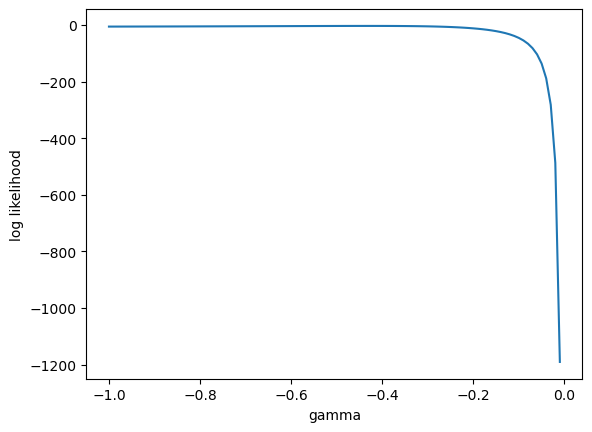

In [7]:
gammas = np.linspace(-1, -0.01, 100)
lls = ll_gamma(gammas)

plt.plot(gammas, lls)
plt.xlabel("gamma")
plt.ylabel("log likelihood")
plt.show()

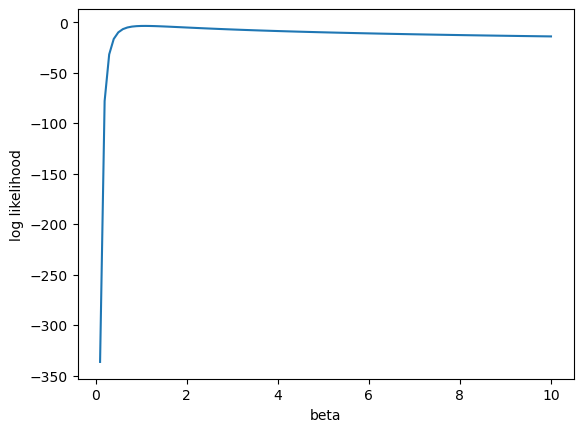

In [8]:
betas = np.linspace(0.1, 10, 100)
lls = ll_beta(betas)
plt.plot(betas, lls)
plt.xlabel("beta")
plt.ylabel("log likelihood")
plt.show()

/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/3617636692.py:16: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(bg_pdf(np.array([1, 2, 3]), 4, beta, gamma)))


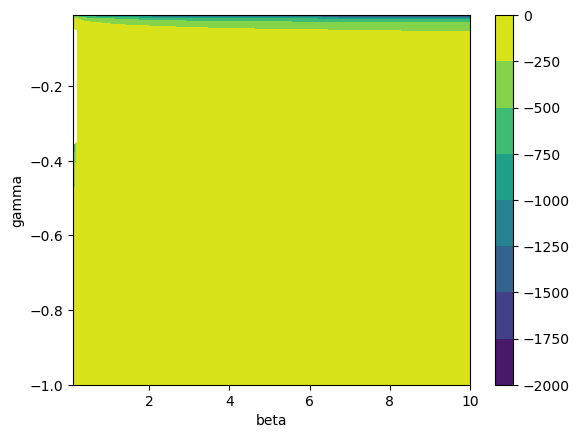

In [9]:
betas = np.linspace(0.1, 10, 100)
gammas = np.linspace(-1, -0.01, 100)
betas, gammas = np.meshgrid(betas, gammas)

lls = ll_beta_gamma(betas, gammas)

plt.contourf(betas, gammas, lls)
plt.xlabel("beta")
plt.ylabel("gamma")
plt.colorbar()

In [10]:
z = np.array([1, 2, 3, 4, 5])
z_star = 6

In [11]:
from scipy.optimize import minimize

In [12]:
mins = minimize(
    lambda x: -ll_beta_gamma(x[0], x[1]),
    x0=[1, -0.5],
    bounds=[(0.01, None), (None, -0.01)],
)

Text(0.5, 0, 'Return Period [years]')

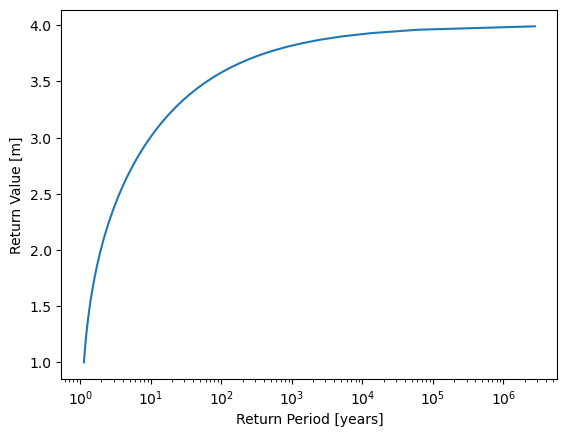

In [13]:
znew = np.linspace(1, 3.99, num=100)
rp = 1 / (1 - bg_cdf(znew, 4, mins.x[0], mins.x[1]))
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")

Text(0.5, 0, 'Return Period [years]')

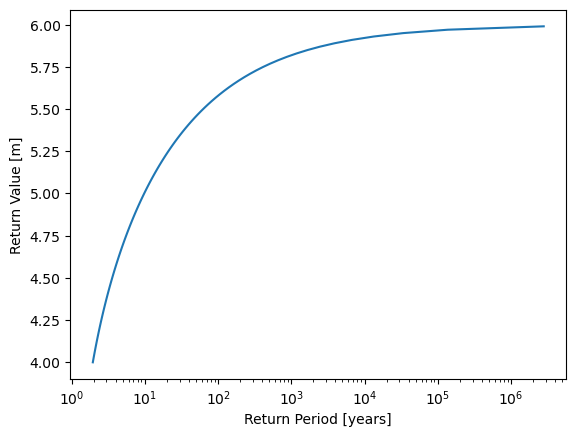

In [14]:
znew = np.linspace(4, 5.99, num=100)

rp = 1 / (1 - bg_cdf(znew, z_star, mins.x[0], mins.x[1]))
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")

In [15]:
import matplotlib.pyplot as plt
from sithom.plot import plot_defaults

plot_defaults()

Text(0.5, 0, 'Return Period [years]')

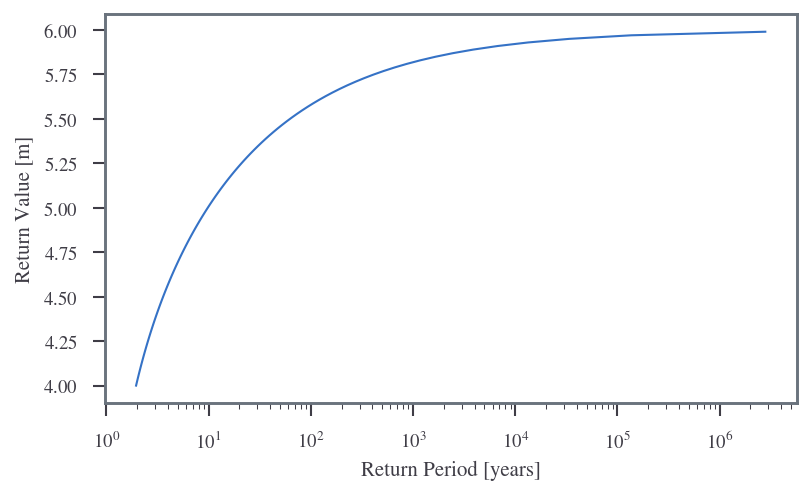

In [16]:
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")
# plot a horizontal line at z_star

In [17]:
from scipy.stats import genextreme
from typing import Tuple, Callable


def return_ll(z: np.ndarray, z_star: float) -> Callable[[float, float], np.ndarray]:
    N = len(z)
    def ll(beta: float, gamma: float) -> float:
        return N * (1/gamma*np.log(beta) + (1+1/gamma)*np.log(gamma)) - np.sum(
              (1+1/gamma)*np.log(gamma/beta*(z-z_star)) + (gamma/beta*(z-z_star))**(-1/gamma)
            )
    return ll

def return_jac(z: np.ndarray, z_star: float) -> Callable[[float, float], np.ndarray]:
    # dl/dbeta, dl/dgamma
    N = len(z)
    def jac_f(beta: float, gamma: float) -> np.ndarray:
        epsilon = gamma / beta * (z - z_star)
        jac = np.zeros([2])
        # dll/beta
        jac[0] = N/gamma/beta + np.sum(epsilon**(-1/gamma-1)*(epsilon) / gamma / beta)
        jac[1] = N * (1/gamma**2*(1 - np.log(beta) - np.log(gamma)) + 1/gamma) - np.sum(-1/(gamma**2) * np.log(z-z_star) + epsilon**(-1/gamma)/(gamma**2)*(np.log(epsilon) -1) )
        return jac
    return jac_f

def return_hess(z: np.ndarray, z_star: float) -> Callable[[float, float], np.ndarray]:
    N = len(z)
    def hess_f(beta: float, gamma: float) -> np.ndarray:
        diff = z - z_star
        epsilon = gamma / beta * diff
        hess = np.zeros([2, 2])
        # dll/beta
        hess[0, 0] = -N/gamma/beta**2 - np.sum(epsilon**(-1/gamma-1)*epsilon**2 / gamma / beta**2)
        hess[1, 1] = -N * (2/(gamma**3)*(1/2 - np.log(beta) - np.log(gamma)) + 1/gamma**2) - 1/gamma**3*np.sum(2*np.log(diff) - 2*epsilon**(-1/gamma)*(np.log(epsilon) -1) + epsilon**(-1/gamma)/gamma * (np.log(epsilon) - 1)**2 + gamma * epsilon**(-1/gamma))
        hess[0, 1] = -N/gamma**2/beta - np.sum(1/(beta*gamma**3) * epsilon**(-1/gamma)*(np.log(epsilon) -1 - gamma) )
        # hessian is symmetric
        hess[1, 0] = hess[0, 1]
        return hess
    return hess_f


def gen_samples_from_gev(z_star: float, beta: float, gamma: float, n: int) -> np.ndarray:
    # generate samples from the gev distribution
    return genextreme.rvs(
        loc=alpha_from_z_star_beta_gamma(z_star, beta, gamma),
        scale=beta,
        c=-gamma,
        size=n,
    )


def return_ll_beta_gamma(
    z: np.ndarray, z_star: float
) -> Callable[[float, float], float]:
    @np.vectorize
    def ll_beta_gamma(beta: float = 1, gamma: float = -0.5) -> float:
        return np.sum(np.log(bg_pdf(z, z_star, beta, gamma)))

    return ll_beta_gamma


def return_ll_alpha_beta_gamma(z: np.ndarray) -> Callable[[float, float, float], float]:
    @np.vectorize
    def ll_alpha_beta_gamma(
        alpha: float = 4, beta: float = 1, gamma: float = -0.5
    ) -> float:
        return np.sum(np.log(gev_pdf(z, alpha, beta, gamma)))

    return ll_alpha_beta_gamma


def min_ll_bg(z: np.ndarray, z_star: float) -> Tuple[float, float]:
    mins = minimize(
        lambda x: -return_ll_beta_gamma(z, z_star)(x[0], x[1]),
        x0=[1, -0.5],
        bounds=[(0.01, None), (None, -0.01)],
    )
    return mins.x[0], mins.x[1]

def min_ll_bg_new(z: np.ndarray, z_star: float) -> Tuple[float, float]:
    mins = minimize(
        lambda x: -return_ll(z, z_star)(x[0], x[1]),
        x0=[1, -0.5],
        bounds=[(0.01, None), (None, -0.01)],
        jac=lambda x: -return_jac(z, z_star)(x[0], x[1]),
        hess=lambda x: -return_hess(z, z_star)(x[0], x[1]),
    )
    return mins.x[0], mins.x[1]

def min_ll_gev(z: np.ndarray, bounded: bool = True) -> Tuple[float, float, float]:
    if bounded:
        tup = (None, -0.01)
    else:
        tup = (None, None)
    mins = minimize(
        lambda x: -return_ll_alpha_beta_gamma(z)(x[0], x[1], x[2]),
        x0=[4, 1, -0.3],
        bounds=[(None, None), (0.01, None), tup],
        jac="3-point",
        hess="3-point",
    )
    return mins.x[0], mins.x[1], mins.x[2]


def fit_gev(z: np.ndarray) -> Tuple[float, float, float]:
    c, mu, sigma = genextreme.fit(z)
    return mu, sigma, -c

In [18]:
c, mu, sigma = genextreme.fit(z)

In [19]:
from sithom.time import timeit


def plot_rp(alpha: float, beta: float, gamma: float, color: str = "blue", label=""):
    z1yr = genextreme.isf(0.8, c=-gamma, loc=alpha, scale=beta)
    z1myr = genextreme.isf(1 / 1_000_000, c=-gamma, loc=alpha, scale=beta)
    znew = np.linspace(z1yr, z1myr, num=100)

    print(z1yr, z1myr)
    if gamma < 0:  # Weibull class have upper bound
        z_star = z_star_from_alpha_beta_gamma(alpha, beta, gamma)
        plt.hlines(z_star, 2, 1_000_000, color=color, linestyles="dashed")
        rp = 1 / (1 - bg_cdf(znew, z_star, beta, gamma))
    else:
        rp = 1 / genextreme.sf(znew, c=-gamma, loc=alpha, scale=beta)
    plt.semilogx(rp, znew, color=color, label=label, alpha=0.5)
    plt.ylabel("Return Value [m]")
    plt.xlabel("Return Period [years]")


@timeit
def plot_fit(
    z_star: float = 7, beta: float = 4, gamma: float = -0.1, n: int = 40, seed: int = 42
) -> None:
    np.random.seed(seed)
    alpha = alpha_from_z_star_beta_gamma(z_star, beta, gamma)
    # create the synthetic data/observations
    zs = gen_samples_from_gev(z_star, beta, gamma, n)
    bg_beta, bg_gamma = min_ll_bg(zs, z_star)
    bg_alpha = alpha_from_z_star_beta_gamma(z_star, bg_beta, bg_gamma)
    bgn_beta, bgn_gamma = min_ll_bg_new(zs, z_star)
    bgn_alpha = alpha_from_z_star_beta_gamma(z_star, bgn_beta, bgn_gamma)
    f_alpha, f_beta, f_gamma = min_ll_gev(zs)
    u_alpha, u_beta, u_gamma = min_ll_gev(zs, bounded=False)
    s_alpha, s_beta, s_gamma = fit_gev(zs)

    f_zstar = z_star_from_alpha_beta_gamma(f_alpha, f_beta, f_gamma)
    u_zstar = z_star_from_alpha_beta_gamma(u_alpha, u_beta, u_gamma)
    print(
        f"True: alpha={alpha}, beta={beta}, gamma={gamma}, z_star={z_star}, 1/100={genextreme.isf(1/100, c=-gamma, loc=alpha, scale=beta)}"
    )
    print(
        f"Max known: alpha={bg_alpha}, beta={bg_beta}, gamma={bg_gamma}, z_star={z_star}, 1/100={genextreme.isf(1/100, c=-bg_gamma, loc=bg_alpha, scale=bg_beta)}"
    )
    print(f"Max known new: alpha={bgn_alpha}, beta={bgn_beta}, gamma={bgn_gamma}, z_star={z_star}, 1/100={genextreme.isf(1/100, c=-bgn_gamma, loc=bgn_alpha, scale=bgn_beta)}")
    print(
        f"Max unknown: alpha={f_alpha}, beta={f_beta}, gamma={f_gamma}, z_star={f_zstar}, 1/100={genextreme.isf(1/100, c=-f_gamma, loc=f_alpha, scale=f_beta)}"
    )
    print(
        f"Unbounded: alpha={u_alpha}, beta={u_beta}, gamma={u_gamma}, zstar={u_zstar}, 1/100={genextreme.isf(1/100, c=-u_gamma, loc=u_alpha, scale=u_beta)}"
    )
    print(
        f"Scipy: alpha={s_alpha}, beta={s_beta}, gamma={s_gamma}, z_star={z_star}, 1/100={genextreme.isf(1/100, c=-s_gamma, loc=s_alpha, scale=s_beta)}"
    )

    plot_rp(alpha, beta, gamma, color="black", label="True")
    plot_rp(bg_alpha, bg_beta, bg_gamma, color="purple", label="Max known")
    # plot_rp(bgn_alpha, bgn_beta, bgn_gamma, color="orange", label="Max known new")
    # plot_rp(f_alpha, f_beta, f_gamma, color="red", label="Bounded, max unknown")
    # plot_rp(u_alpha, u_beta, u_gamma, color="green", label="Unbounded, max unknown")
    plot_rp(s_alpha, s_beta, s_gamma, color="blue", label="Scipy GEV")
    sorted_zs = np.sort(zs)
    empirical_rps = len(zs) / np.arange(1, len(zs) + 1)[::-1]
    plt.scatter(
        empirical_rps,
        sorted_zs,
        s=3,
        alpha=0.8,
        color="black",
        label="Simulated data points",
    )
    plt.legend()


# @timeit
def try_fit(
        
    z_star: float = 7, beta: float = 4, gamma: float = -0.1, n: int = 40, seed: int = 42,
    quantiles=[1/100, 1/200]
) -> None:
    np.random.seed(seed)
    alpha = alpha_from_z_star_beta_gamma(z_star, beta, gamma)
    zs = gen_samples_from_gev(z_star, beta, gamma, n)
    bg_beta, bg_gamma = min_ll_bg(zs, z_star)
    bg_alpha = alpha_from_z_star_beta_gamma(z_star, bg_beta, bg_gamma)
    s_alpha, s_beta, s_gamma = fit_gev(zs)

    return genextreme.isf(quantiles, c=-gamma, loc=alpha, scale=beta), genextreme.isf(quantiles, c=-bg_gamma, loc=bg_alpha, scale=bg_beta), genextreme.isf(quantiles, c=-s_gamma, loc=s_alpha, scale=s_beta)


def try_fits(z_star=7, beta=1, gamma=-0.3, seed=100, ns=[20, 30, 40, 50, 60, 75, 100, 200, 500, 1000]):
    results = []
    for n in ns:
        results.append(try_fit(z_star=z_star, beta=beta, gamma=gamma, n=n, quantiles=[1/100, 1/500], seed=seed))
    return xr.Dataset(data_vars={"rv": (("number", "fit", "rp", "seed"),np.expand_dims(np.array(results), -1), {"units": "m"})}, coords={"number": ns, "fit": ["true", "max_known", "scipy"], "rp": (("rp"), [100, 500], {"units": "years"}), "seed": (("seed"), [seed])})["rv"]


# try_fit(z_star=7, beta=4, gamma=-0.5, n=100)

/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/292403709.py:56: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(bg_pdf(z, z_star, beta, gamma)))
/Users/simon/micromamba/envs/tcpips/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/292403709.py:56: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(bg_pdf(z, z_star, beta, gamma)))
/Users/simon/micromamba/envs/tcpips/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/292403709.py:56: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(bg_pdf(z, z_star, beta, gamma)))
/Users/simon/micromamba/envs/tcpips/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576:

<xarray.DataArray 'rv' (number: 10, fit: 3, rp: 2, seed: 50)>
array([[[[6.16144236, 6.16144236, 6.16144236, ..., 6.16144236,
          6.16144236, 6.16144236],
         [6.48320519, 6.48320519, 6.48320519, ..., 6.48320519,
          6.48320519, 6.48320519]],

        [[6.30717415, 6.31122221, 6.17097862, ..., 6.17409847,
          6.12697586, 6.15318105],
         [6.59026592, 6.58989646, 6.48733431, ..., 6.5038773 ,
          6.45324281, 6.47909945]],

        [[5.76515304, 7.99486708, 6.10176314, ..., 5.32732514,
          5.46672068, 6.97146757],
         [5.85244116, 9.93168883, 6.38470543, ..., 5.34836034,
          5.55210151, 7.92198396]]],


       [[[6.16144236, 6.16144236, 6.16144236, ..., 6.16144236,
          6.16144236, 6.16144236],
         [6.48320519, 6.48320519, 6.48320519, ..., 6.48320519,
          6.48320519, 6.48320519]],
...
        [[6.19107837, 6.29631204, 6.19836709, ..., 6.17704701,
          6.10874747, 6.23819365],
         [6.53385902, 6.6915756 , 6.53089011, ..., 6.48711934,
          6.4217715 , 6.60807338]]],


       [[[6.16144236, 6.16144236, 6.16144236, ..., 6.16144236,
          6.16144236, 6.16144236],
         [6.48320519, 6.48320519, 6.48320519, ..., 6.48320519,
          6.48320519, 6.48320519]],

        [[6.15685951, 6.14390486, 6.21771239, ..., 6.18666366,
          6.15176565, 6.13840179],
         [6.47972318, 6.46854282, 6.52776185, ..., 6.50180004,
          6.47399155, 6.46706719]],

        [[6.20005944, 6.26067179, 6.19550908, ..., 6.19046934,
          6.19180442, 6.2056929 ],
         [6.54663456, 6.6539359 , 6.49426238, ..., 6.50757082,
          6.5360193 , 6.57206056]]]])
Coordinates:
  * number   (number) int64 20 30 40 50 60 75 100 200 500 1000
  * fit      (fit) <U9 'true' 'max_known' 'scipy'
  * rp       (rp) int64 100 500
  * seed     (seed) int64 0 204 408 612 816 1020 ... 9183 9387 9591 9795 10000
Attributes:
    units:    m

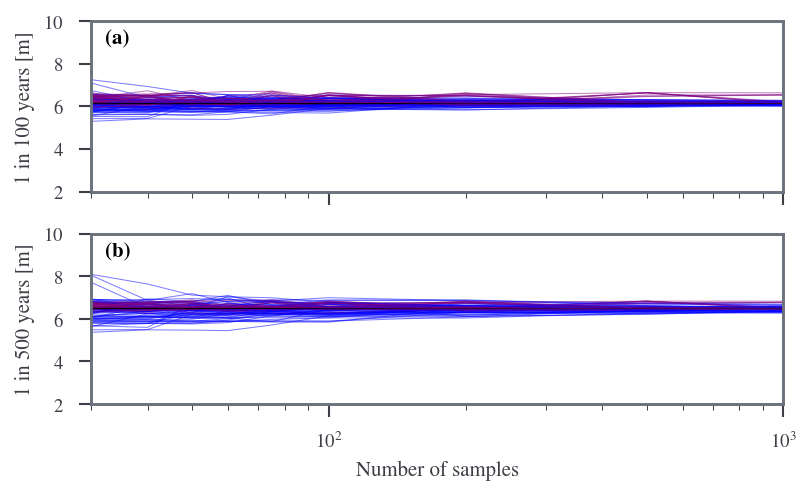

In [20]:
from sithom.plot import plot_defaults, label_subplots
# res = try_fits()
# res
res_ds_list = []
fig, axs = plt.subplots(2, 1,sharey=True, sharex=True)
seeds = np.linspace(0, 10000, num=50).astype(int)

for seed in seeds:
    res = try_fits(seed=seed)
    numbers = res.number.values
    axs[0].plot(numbers, res.isel(rp=0, fit=0).values, alpha=0.5, color="black", linewidth=0.5)
    axs[1].plot(numbers, res.isel(rp=1, fit=0).values, alpha=0.5, color="black", linewidth=0.5)
    axs[0].plot(numbers, res.isel(rp=0, fit=1).values, alpha=0.5, color="purple", linewidth=0.5)
    axs[1].plot(numbers, res.isel(rp=1, fit=1).values, alpha=0.5, color="purple", linewidth=0.5)
    axs[0].plot(numbers, res.isel(rp=0, fit=2).values, alpha=0.5, color="blue", linewidth=0.5)
    axs[1].plot(numbers, res.isel(rp=1, fit=2).values, alpha=0.5, color="blue", linewidth=0.5)
    res_ds_list.append(res)

axs[0].set_xlim([30, 1000])
axs[0].set_ylim([2, 10])
axs[0].set_ylabel("1 in 100 years [m]")
axs[1].set_ylabel("1 in 500 years [m]")
axs[1].set_xlabel("Number of samples")
# set the x-axis to log scale
axs[0].set_xscale("log")
label_subplots(axs)
res_ds = xr.concat(res_ds_list, dim="seed")
res_ds

In [21]:
res_ds.mean(dim="seed"), res_ds.std(dim="seed")

(<xarray.DataArray 'rv' (number: 10, fit: 3, rp: 2)>
 array([[[6.16144236, 6.48320519],
         [6.2422145 , 6.54147425],
         [6.17462547, 6.66322936]],
 
        [[6.16144236, 6.48320519],
         [6.30903846, 6.59504501],
         [6.03500142, 6.3240633 ]],
 
        [[6.16144236, 6.48320519],
         [6.27385798, 6.56796399],
         [6.00838489, 6.28264248]],
 
        [[6.16144236, 6.48320519],
         [6.26623525, 6.56228455],
         [6.04482802, 6.32946718]],
 
        [[6.16144236, 6.48320519],
         [6.19799899, 6.510626  ],
         [6.06436791, 6.35404   ]],
 
        [[6.16144236, 6.48320519],
         [6.25586715, 6.5530013 ],
         [6.07921263, 6.36624244]],
 
        [[6.16144236, 6.48320519],
         [6.27252711, 6.56592732],
         [6.09545834, 6.38680474]],
 
        [[6.16144236, 6.48320519],
         [6.2317217 , 6.53476517],
         [6.1273283 , 6.43923846]],
 
        [[6.16144236, 6.48320519],
         [6.22847254, 6.5321505 ],
         [6.1

In [22]:
std = res_ds.std(dim="seed")
std

<xarray.DataArray 'rv' (number: 10, fit: 3, rp: 2)>
array([[[8.88178420e-16, 4.44089210e-15],
        [1.84538264e-01, 1.44158458e-01],
        [8.71344069e-01, 1.77437538e+00]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.72362718e-01, 1.30604549e-01],
        [3.77846931e-01, 5.68060029e-01]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.80806752e-01, 1.33686832e-01],
        [2.83407899e-01, 4.15389692e-01]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.79174765e-01, 1.34370102e-01],
        [2.51356448e-01, 3.58330038e-01]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.44190905e-01, 1.10480305e-01],
        [2.50857784e-01, 3.60655106e-01]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.83128876e-01, 1.38275557e-01],
        [2.08122013e-01, 2.87544157e-01]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.67234913e-01, 1.26519780e-01],
        [1.84286896e-01, 2.61623327e-01]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.62479003e-01, 1.23282225e-01],
        [1.37467339e-01, 1.95595772e-01]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.60404172e-01, 1.18176247e-01],
        [8.96902699e-02, 1.20909794e-01]],

       [[8.88178420e-16, 4.44089210e-15],
        [1.11686333e-01, 8.33784539e-02],
        [6.38874281e-02, 9.05779090e-02]]])
Coordinates:
  * number   (number) int64 20 30 40 50 60 75 100 200 500 1000
  * fit      (fit) <U9 'true' 'max_known' 'scipy'
  * rp       (rp) int64 100 500

In [23]:
mn = res_ds.mean(dim="seed")
std = res_ds.std(dim="seed")

In [24]:
# 5th and 95th percentiles not assuming gaussian distribution, directly from the data
p5 = res_ds.quantile(0.05, dim="seed")
p95 = res_ds.quantile(0.95, dim="seed")

In [25]:
def plot_vals(res):
    fig, axs = plt.subplots(2, 1, sharey=True, sharex=True)
    numbers = res.number.values
    axs[0].plot(
        numbers, res.isel(rp=0, fit=0).values, alpha=0.5, color="black", linewidth=0.5
    )
    axs[1].plot(
        numbers, res.isel(rp=1, fit=0).values, alpha=0.5, color="black", linewidth=0.5
    )
    axs[0].plot(
        numbers, res.isel(rp=0, fit=1).values, alpha=0.5, color="purple", linewidth=0.5
    )
    axs[1].plot(
        numbers, res.isel(rp=1, fit=1).values, alpha=0.5, color="purple", linewidth=0.5
    )
    axs[0].plot(
        numbers, res.isel(rp=0, fit=2).values, alpha=0.5, color="blue", linewidth=0.5
    )
    axs[1].plot(
        numbers, res.isel(rp=1, fit=2).values, alpha=0.5, color="blue", linewidth=0.5
    )
    axs[0].set_xscale("log")
    axs[1].set_xlabel("Number of samples")
    axs[0].set_ylabel("1 in 100 years [m]")
    axs[1].set_ylabel("1 in 500 years [m]")
    plt.show()
    plt.clf()

# plot_vals(mn)

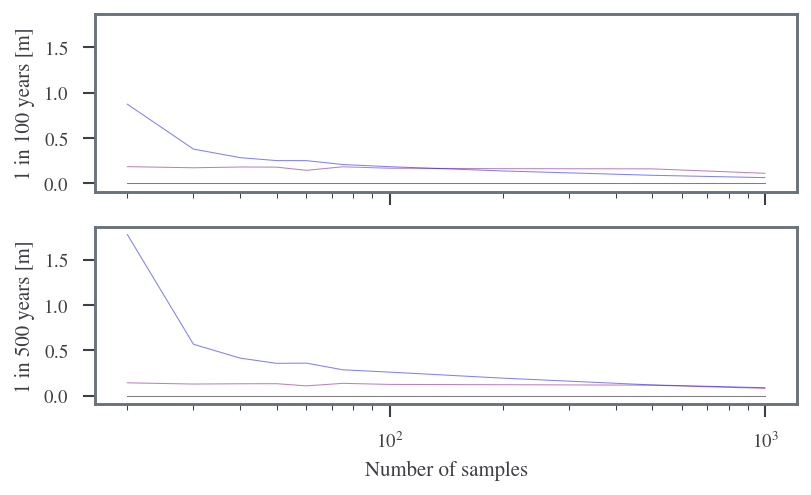

<Figure size 826.772x510.973 with 0 Axes>

In [26]:
plot_vals(std)

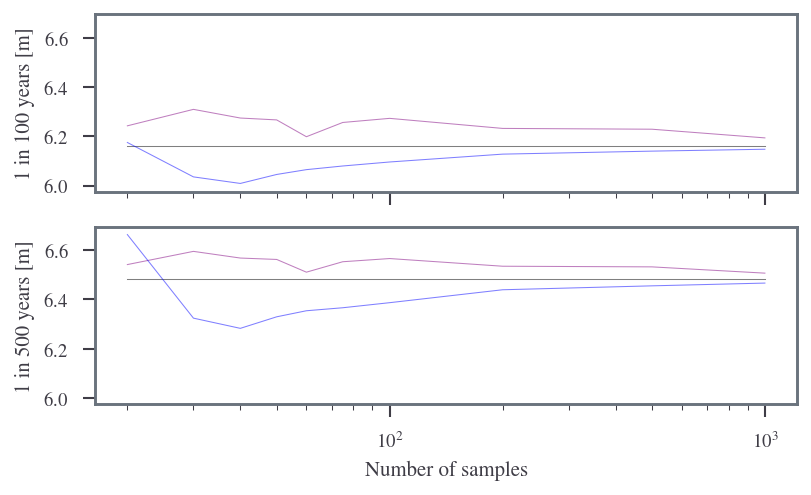

<Figure size 826.772x510.973 with 0 Axes>

In [27]:
plot_vals(mn)

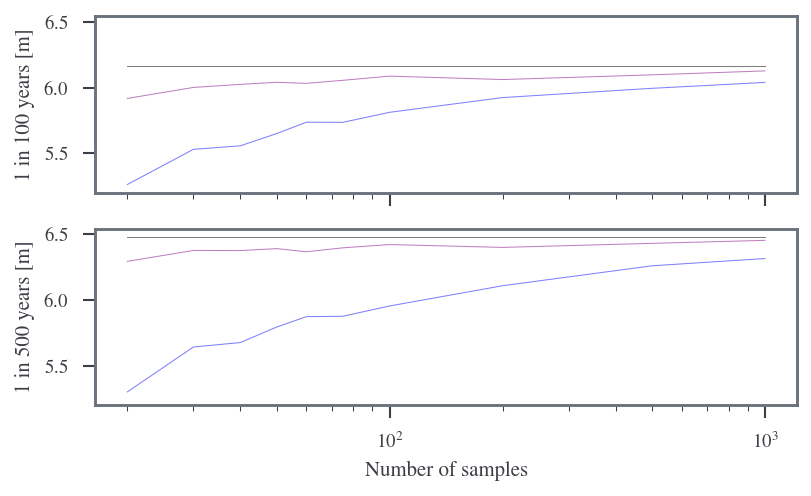

<Figure size 826.772x510.973 with 0 Axes>

In [28]:
plot_vals(p5)

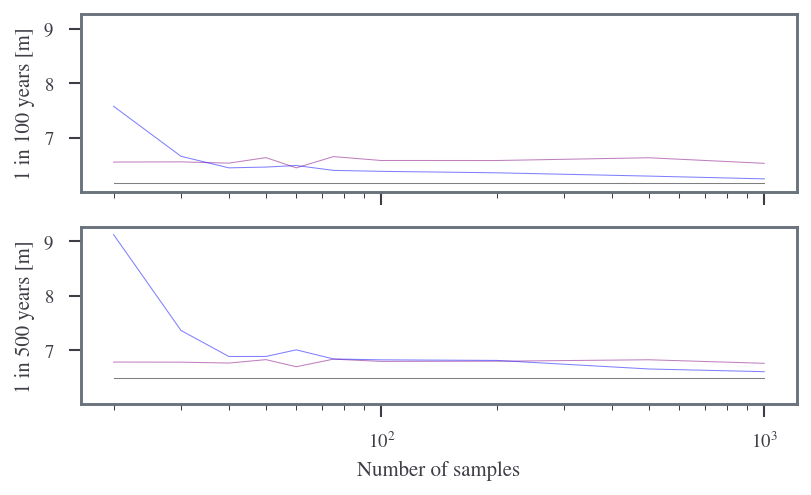

<Figure size 826.772x510.973 with 0 Axes>

In [29]:
plot_vals(p95)

/Users/simon/micromamba/envs/tcpips/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/292403709.py:8: RuntimeWarning: invalid value encountered in log
  return N * (1/gamma*np.log(beta) + (1+1/gamma)*np.log(gamma)) - np.sum(
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/292403709.py:21: RuntimeWarning: invalid value encountered in log
  jac[1] = N * (1/gamma**2*(1 - np.log(beta) - np.log(gamma)) + 1/gamma) - np.sum(-1/(gamma**2) * np.log(z-z_star) + epsilon**(-1/gamma)/(gamma**2)*(np.log(epsilon) -1) )
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/2759599665.py:18: RuntimeWarning: invalid value encountered in power
  * (1 + gamma * (z - alpha) / beta) ** (-1 / gamma - 1)
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_131

True: alpha=3.6666666666666665, beta=1, gamma=-0.3, z_star=7, 1/100=6.161442364550341
Max known: alpha=3.556640230006106, beta=0.991946506787989, gamma=-0.28807518616904443, z_star=7, 1/100=6.084917608896822
Max known new: alpha=5.0, beta=1.0, gamma=-0.5, z_star=7, 1/100=6.799497273300322
Max unknown: alpha=4.0, beta=1.0, gamma=-0.3, z_star=7.333333333333334, 1/100=6.494775697883674
Unbounded: alpha=4.0, beta=1.0, gamma=-0.3, zstar=7.333333333333334, 1/100=6.494775697883674
Scipy: alpha=3.567151943585844, beta=0.999660289156296, gamma=-0.3078035170537352, z_star=7, 1/100=6.0266621039031145
3.1551357262333695 6.947170218993493
3.050700068420195 6.935652549172064
3.054821490594219 6.768661731905722
'plot_fit'  0.04181 s 



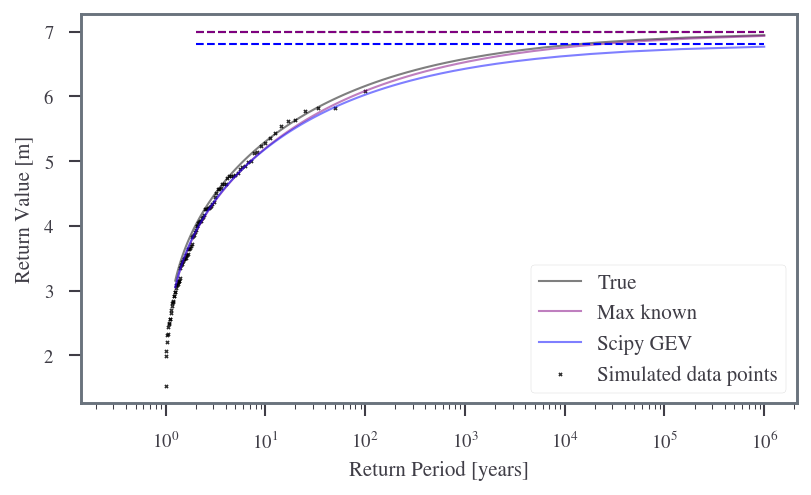

In [30]:
plot_fit(z_star=7, beta=1, gamma=-0.3, n=100)

/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/292403709.py:56: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(bg_pdf(z, z_star, beta, gamma)))
/Users/simon/micromamba/envs/tcpips/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/292403709.py:8: RuntimeWarning: invalid value encountered in log
  return N * (1/gamma*np.log(beta) + (1+1/gamma)*np.log(gamma)) - np.sum(
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/292403709.py:21: RuntimeWarning: invalid value encountered in log
  jac[1] = N * (1/gamma**2*(1 - np.log(beta) - np.log(gamma)) + 1/gamma) - np.sum(-1/(gamma**2) * np.log(z-z_star) + epsilon**(-1/gamma)/(gamma**2)*(np.log(epsilon) -1) )
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_13180/2759599665.py:18: RuntimeWarning: invalid value encountered in power
  

True: alpha=6.0, beta=1, gamma=-0.2, z_star=11, 1/100=9.007464263401896
Max known: alpha=5.44964978081001, beta=1.714996326525749, gamma=-0.3089888491353674, z_star=11, 1/100=9.660272529718117
Max known new: alpha=9.0, beta=1.0, gamma=-0.5, z_star=11, 1/100=10.799497273300322
Max unknown: alpha=4.0, beta=1.0, gamma=-0.3, z_star=7.333333333333334, 1/100=6.494775697883674
Unbounded: alpha=4.0, beta=1.0, gamma=-0.3, zstar=7.333333333333334, 1/100=6.494775697883674
Scipy: alpha=5.895402723335081, beta=0.9847508852044449, gamma=-0.20121773143782956, z_star=11, 1/100=8.849977173670775
5.50073244528908 10.684521296212022
4.570452353224338 10.922306021757176
5.403603812449014 10.485723157033915
'plot_fit'  0.05203 s 



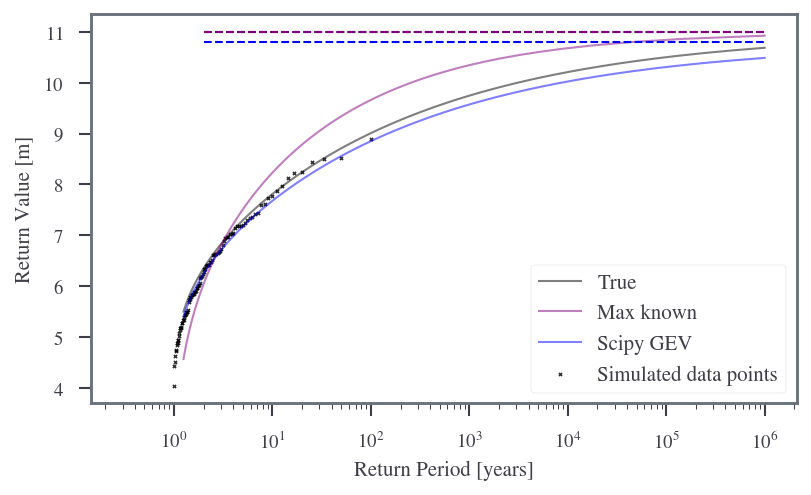

In [31]:
plot_fit(z_star=11, beta=1, gamma=-0.2, n=100)